# **Education Report**
### Team:Cindyl5
Members: Yiyu Wang, Cindy Yawei Lin, Wenxuan Yu.

In this project, we will be looking at edX online course data from Harvard and MIT to predict completion of an online course based on the activity of students.

In [138]:
# Downloads the files to Colab instance.
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_train.csv', 
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_test.csv', 
          'edx_test.csv')

In [139]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# **1.Data preparation**

### 1.1 Investigate data
In this section, we'll inspect both the train data set and the test data set to see the information provided in these datasets.

In [140]:
# inspect train dataset
df_train = pd.read_csv("edx_train.csv")
df_train.head()

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130545492,1,1,1,1,United States,Master's,1984.0,m,1,3/10/13,7/29/13,1161.0,50.0,NaN,12.0,0
1,HarvardX/ER22x/2013_Spring,MHxPC130536944,1,1,1,1,United Kingdom,Master's,1985.0,f,0.85,3/13/13,8/1/13,1360.0,10.0,NaN,29.0,0
2,HarvardX/CS50x/2012,MHxPC130442298,1,1,1,1,India,NaN,NaN,NaN,1,8/2/12,7/25/13,77.0,18.0,NaN,7.0,0
3,HarvardX/ER22x/2013_Spring,MHxPC130273564,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,0.85,1/23/13,8/13/13,1425.0,29.0,NaN,34.0,0
4,HarvardX/CS50x/2012,MHxPC130247761,1,1,0,0,United States,Secondary,1989.0,m,0,3/5/13,3/5/13,6.0,1.0,NaN,1.0,0


In [141]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8758 entries, 0 to 8757
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_id          8758 non-null   object 
 1   userid_DI          8758 non-null   object 
 2   registered         8758 non-null   int64  
 3   viewed             8758 non-null   int64  
 4   explored           8758 non-null   int64  
 5   certified          8758 non-null   int64  
 6   final_cc_cname_DI  8758 non-null   object 
 7   LoE_DI             7792 non-null   object 
 8   YoB                7844 non-null   float64
 9   gender             7983 non-null   object 
 10  grade              8388 non-null   object 
 11  start_time_DI      8758 non-null   object 
 12  last_event_DI      7250 non-null   object 
 13  nevents            7119 non-null   float64
 14  ndays_act          7119 non-null   float64
 15  nplay_video        2011 non-null   float64
 16  nchapters          6195 

In [142]:
# inspect test dataset
df_test = pd.read_csv("edx_test.csv")
df_test.head()

,course_id,userid_DI,registered,viewed,explored,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130476531,1,1,1,United Kingdom,Secondary,1971.0,m,1,10/30/12,6/27/13,132.0,34.0,NaN,12.0,0
1,HarvardX/CB22x/2013_Spring,MHxPC130559898,1,0,0,Other South Asia,Bachelor's,1984.0,m,NaN,2/6/13,11/17/13,NaN,NaN,NaN,NaN,0
2,HarvardX/PH207x/2012_Fall,MHxPC130552712,1,1,1,Egypt,Bachelor's,1985.0,f,0.81,10/20/12,1/18/13,2650.0,32.0,96.0,15.0,0
3,HarvardX/PH278x/2013_Spring,MHxPC130394971,1,1,1,Nigeria,Secondary,1988.0,m,0.87,12/27/12,8/22/13,999.0,17.0,13.0,8.0,0
4,HarvardX/ER22x/2013_Spring,MHxPC130191077,1,1,1,Other Middle East/Central Asia,NaN,NaN,NaN,0.9,5/31/13,9/7/13,2130.0,24.0,NaN,29.0,0


In [143]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_id          2920 non-null   object 
 1   userid_DI          2920 non-null   object 
 2   registered         2920 non-null   int64  
 3   viewed             2920 non-null   int64  
 4   explored           2920 non-null   int64  
 5   final_cc_cname_DI  2920 non-null   object 
 6   LoE_DI             2569 non-null   object 
 7   YoB                2610 non-null   float64
 8   gender             2660 non-null   object 
 9   grade              2790 non-null   object 
 10  start_time_DI      2920 non-null   object 
 11  last_event_DI      2361 non-null   object 
 12  nevents            2319 non-null   float64
 13  ndays_act          2319 non-null   float64
 14  nplay_video        659 non-null    float64
 15  nchapters          2012 non-null   float64
 16  nforum_posts       2920 

### 1.2 preprocess data
We can see that not all features would be neccessary for predicting the output so we'll select some features that would be useful to be included in our models. We think that some of the most important features for our final models include the grades that students got and how often they interact with class materials.

In [144]:
# select the features that would be useful for our prediction
features = [
 'nplay_video',
 'viewed',
 'explored',
 'LoE_DI',
 'gender',
 'grade',
 'nevents',
 'ndays_act',
 'nchapters',
 'nforum_posts',       
]

target = 'certified'

# inspect the train data after filtering features
df_train = df_train[features + [target]]
df_train.head()

,nplay_video,viewed,explored,LoE_DI,gender,grade,nevents,ndays_act,nchapters,nforum_posts,certified
0,NaN,1,1,Master's,m,1,1161.0,50.0,12.0,0,1
1,NaN,1,1,Master's,f,0.85,1360.0,10.0,29.0,0,1
2,NaN,1,1,NaN,NaN,1,77.0,18.0,7.0,0,1
3,NaN,1,1,Bachelor's,m,0.85,1425.0,29.0,34.0,0,1
4,NaN,1,0,Secondary,m,0,6.0,1.0,1.0,0,0


In [145]:
# inspect the proccessed test data after filtering features
df_test_proccessed = df_test[features]
df_test_proccessed.head()

,nplay_video,viewed,explored,LoE_DI,gender,grade,nevents,ndays_act,nchapters,nforum_posts
0,NaN,1,1,Secondary,m,1,132.0,34.0,12.0,0
1,NaN,0,0,Bachelor's,m,NaN,NaN,NaN,NaN,0
2,96.0,1,1,Bachelor's,f,0.81,2650.0,32.0,15.0,0
3,13.0,1,1,Secondary,m,0.87,999.0,17.0,8.0,0
4,NaN,1,1,NaN,NaN,0.9,2130.0,24.0,29.0,0


### 2.2 Cleaning up data
From the table, we can see that there're a lot of NaN values and they lay in both the categorical and numerical columns. In this section, we'll be dealing with those value in order to train the models and make predictions.

In [146]:
# the grade column is shown as an object type, so we convert it into numeric to make it easier for processing
df_train['grade'] = pd.to_numeric(df_train['grade'],errors = 'coerce')
df_test_proccessed['grade'] = pd.to_numeric(df_test_proccessed['grade'],errors = 'coerce')
# The train dataset contains a lot of NaN values, we can replace the categorical values with none and the numerical values with 0
df_train['gender'].replace(to_replace = np.nan, value = "no gender",inplace=True)
df_train['LoE_DI'].replace(to_replace = np.nan, value = "no degree", inplace=True)
df_train = df_train.fillna(0)
# inspect the train data set after cleaning up the data
df_train.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,nplay_video,viewed,explored,LoE_DI,gender,grade,nevents,ndays_act,nchapters,nforum_posts,certified
0,0.0,1,1,Master's,m,1.00,1161.0,50.0,12.0,0,1
1,0.0,1,1,Master's,f,0.85,1360.0,10.0,29.0,0,1
2,0.0,1,1,no degree,no gender,1.00,77.0,18.0,7.0,0,1
3,0.0,1,1,Bachelor's,m,0.85,1425.0,29.0,34.0,0,1
4,0.0,1,0,Secondary,m,0.00,6.0,1.0,1.0,0,0
5,0.0,1,1,Bachelor's,m,1.00,254.0,40.0,12.0,0,1
6,0.0,0,0,Master's,m,0.00,1.0,1.0,0.0,0,0
7,0.0,1,1,Secondary,m,0.63,1781.0,18.0,32.0,0,1
8,0.0,0,0,Master's,f,0.00,0.0,0.0,0.0,0,0
9,288.0,1,0,Secondary,m,0.53,1214.0,8.0,4.0,0,1


Since as sklearn implemented most of the models, most of them are only able to handle numerical features. So we are using one-hot encoding to transform the categorical features into numerical features that takes on the value 0 or 1

In [147]:
# Using one-hot encoding to process the categorical features in train dataset into numerical features
df_train = pd.get_dummies(df_train)
features = list(df_train.columns)
features.remove('certified')
# inspect the train data
df_train.head(10)

,nplay_video,viewed,explored,grade,nevents,ndays_act,nchapters,nforum_posts,certified,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,LoE_DI_no degree,gender_f,gender_m,gender_no gender
0,0.0,1,1,1.00,1161.0,50.0,12.0,0,1,0,0,0,1,0,0,0,1,0
1,0.0,1,1,0.85,1360.0,10.0,29.0,0,1,0,0,0,1,0,0,1,0,0
2,0.0,1,1,1.00,77.0,18.0,7.0,0,1,0,0,0,0,0,1,0,0,1
3,0.0,1,1,0.85,1425.0,29.0,34.0,0,1,1,0,0,0,0,0,0,1,0
4,0.0,1,0,0.00,6.0,1.0,1.0,0,0,0,0,0,0,1,0,0,1,0
5,0.0,1,1,1.00,254.0,40.0,12.0,0,1,1,0,0,0,0,0,0,1,0
6,0.0,0,0,0.00,1.0,1.0,0.0,0,0,0,0,0,1,0,0,0,1,0
7,0.0,1,1,0.63,1781.0,18.0,32.0,0,1,0,0,0,0,1,0,0,1,0
8,0.0,0,0,0.00,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0
9,288.0,1,0,0.53,1214.0,8.0,4.0,0,1,0,0,0,0,1,0,0,1,0


In [148]:
# The test dataset also contains a lot of NaN values, we can replace the categorical values with none and the numerical values with 0
df_test_proccessed['gender'].replace(to_replace = np.nan, value = "no gender",inplace=True)
df_test_proccessed['LoE_DI'].replace(to_replace = np.nan, value = "no degree", inplace=True)
df_test_proccessed = df_test_proccessed.fillna(0)
# inspect the test data set after cleaning up the data
df_test_proccessed.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,nplay_video,viewed,explored,LoE_DI,gender,grade,nevents,ndays_act,nchapters,nforum_posts
0,0.0,1,1,Secondary,m,1.00,132.0,34.0,12.0,0
1,0.0,0,0,Bachelor's,m,0.00,0.0,0.0,0.0,0
2,96.0,1,1,Bachelor's,f,0.81,2650.0,32.0,15.0,0
3,13.0,1,1,Secondary,m,0.87,999.0,17.0,8.0,0
4,0.0,1,1,no degree,no gender,0.90,2130.0,24.0,29.0,0
5,0.0,0,0,Secondary,m,0.00,2.0,1.0,0.0,0
6,0.0,0,0,Bachelor's,m,0.00,0.0,0.0,0.0,0
7,2.0,1,0,Secondary,f,0.00,17.0,1.0,2.0,0
8,0.0,1,1,Secondary,m,0.94,1947.0,16.0,34.0,0
9,0.0,1,1,Bachelor's,m,1.00,314.0,31.0,12.0,0


In [149]:
# Using one-hot encoding to process the categorical features in test dataset into numerical features
df_test_proccessed = pd.get_dummies(df_test_proccessed)
features_test = list(df_test_proccessed.columns)
# inspect the test data
df_test_proccessed.head(10)

,nplay_video,viewed,explored,grade,nevents,ndays_act,nchapters,nforum_posts,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,LoE_DI_no degree,gender_f,gender_m,gender_no gender
0,0.0,1,1,1.00,132.0,34.0,12.0,0,0,0,0,0,1,0,0,1,0
1,0.0,0,0,0.00,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0
2,96.0,1,1,0.81,2650.0,32.0,15.0,0,1,0,0,0,0,0,1,0,0
3,13.0,1,1,0.87,999.0,17.0,8.0,0,0,0,0,0,1,0,0,1,0
4,0.0,1,1,0.90,2130.0,24.0,29.0,0,0,0,0,0,0,1,0,0,1
5,0.0,0,0,0.00,2.0,1.0,0.0,0,0,0,0,0,1,0,0,1,0
6,0.0,0,0,0.00,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0
7,2.0,1,0,0.00,17.0,1.0,2.0,0,0,0,0,0,1,0,1,0,0
8,0.0,1,1,0.94,1947.0,16.0,34.0,0,0,0,0,0,1,0,0,1,0
9,0.0,1,1,1.00,314.0,31.0,12.0,0,1,0,0,0,0,0,0,1,0


# **2.Models Training**
In this section, we'll be using three classifiers to train different models, then compare the models to pick out the best model to use for prediction.

In [150]:
# spliting the test data into test set and validation set
train_data, validation_data = train_test_split(df_train, test_size=0.2, random_state=6)
test_data = df_test_proccessed

## 2.1 Decision Tree Classifier
Initially, we trained the model and make prediction without finding the right fit, resulting in validation accuracy score of 1, which could be due to overfitting. So then we first try to find the best parameters for the models then train the model and make predictions.


In [151]:
x_train = train_data[features]
y_train = train_data[target]
x_validation = validation_data[features]
y_validation = validation_data[target]
# find best parameter
hyperparameter_tree = {'min_samples_leaf':[1, 10, 50, 100, 200, 300], 'max_depth': [1, 5, 10, 15, 20]}
search_tree = GridSearchCV(DecisionTreeClassifier(random_state=6), param_grid=hyperparameter_tree, cv=6, return_train_score=True).fit(x_train, y_train)
best_para_tree = search_tree.best_params_

# train model
model_tree = DecisionTreeClassifier(random_state=6, min_samples_leaf=best_para_tree['min_samples_leaf'], max_depth=best_para_tree['max_depth']).fit(x_train, y_train)

# make prediction using decision tree model and get train and validation accuracy
predict_tree_train = model_tree.predict(x_train)
train_accuracy = accuracy_score(y_train, predict_tree_train)
prediction_tree = model_tree.predict(x_validation)
validation_accuracy_tree = accuracy_score(y_validation, prediction_tree)
print(train_accuracy)
print(validation_accuracy_tree)

0.9972880388238653
0.9988584474885844


## 2.2 Random Forest

In [152]:
# find best parameter
hyperparameter_forest = {'min_samples_leaf':[1, 10, 50, 100, 200, 300], 'max_depth': [1, 5, 10, 15, 20], 'n_estimators':[1, 2, 5, 10, 30, 50, 100]}
search_forest = GridSearchCV(RandomForestClassifier(random_state=6), param_grid=hyperparameter_forest, cv=6, return_train_score=True).fit(x_train, y_train)

best_para_forest = search_forest.best_params_

# train model
model_forest = RandomForestClassifier(random_state=6, min_samples_leaf=best_para_forest['min_samples_leaf'],
                                      max_depth=best_para_forest['max_depth'], n_estimators=best_para_forest['n_estimators']).fit(x_train, y_train)

# make prediction using random forest model and get train and validation accuracy
predict_forest_train = model_forest.predict(x_train)
train_accuracy_forest = accuracy_score(y_train, predict_forest_train)
prediction_forest_valid = model_forest.predict(x_validation)
validation_accuracy_forest = accuracy_score(y_validation, prediction_forest_valid)
print(train_accuracy_forest)
print(validation_accuracy_forest)

1.0
0.9988584474885844


## 2.3 K-Nearest Model

In [153]:
hyperparameter_knn = {'n_neighbors': range(1, 50)}
search_knn = GridSearchCV(KNeighborsClassifier(), hyperparameter_knn).fit(x_train, y_train)
search_knn.best_params_
predict_knn_train = search_knn.predict(x_train)
train_accuracy_knn = accuracy_score(predict_knn_train, y_train)
validation_accuracy_knn = accuracy_score(y_validation, search_knn.predict(x_validation))
print(train_accuracy_knn)
print(validation_accuracy_knn)


0.9695974878675421
0.9571917808219178


# **3. compare models**
3.1 The ROC curve can show straightforward curves comparing the three models. From this graph,we can see that the random forest model has a relatively largest area under the curve among these three models. 

ROC curves reference:https://www.dezyre.com/recipes/plot-roc-curve-in-python

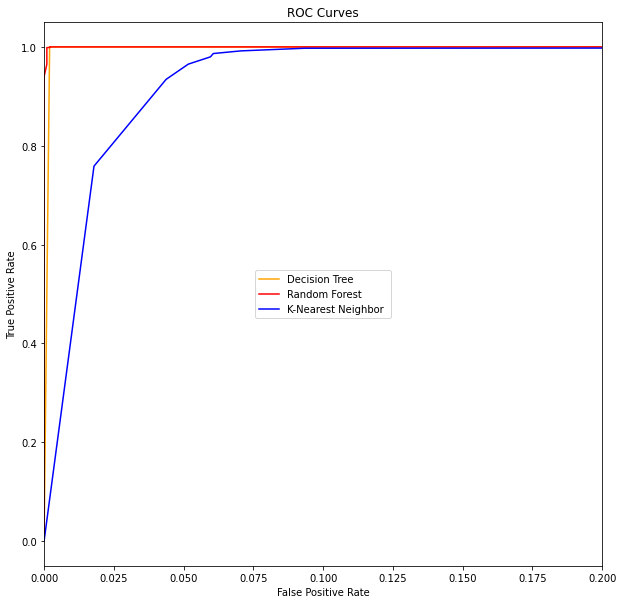

In [154]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# get roc auc scores
y_score1 = model_tree.predict_proba(x_validation)[:,1]
y_score2 = model_forest.predict_proba(x_validation)[:,1]
y_score3 = search_knn.predict_proba(x_validation)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_validation, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_validation, y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_validation, y_score3)

plt.subplots(1, figsize=(10,10))
plt.title('ROC Curves')
plt.plot(false_positive_rate1, true_positive_rate1, color="orange", linestyle="solid")
plt.plot(false_positive_rate2, true_positive_rate2, color="red", linestyle="solid")
plt.plot(false_positive_rate3, true_positive_rate3, color="blue", linestyle="solid")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0, 0.2])
plt.legend(("Decision Tree", "Random Forest", "K-Nearest Neighbor "), loc="center")

plt.show()


3.2 We can see that bsed on the ROC curve, the decision tree model and the random forest model seems to be very similar, so we decided to use another method to further explore how the models perform. Then draw out a graph to have a more obvious difference.
Accuracy vs Max depth, reference, HW5:https://edstem.org/us/courses/4914/assessments/15955

Depth 1
Depth 3
Depth 5
Depth 7
Depth 9
Depth 11
Depth 13
Depth 15
Depth 17
Depth 19
Depth 21
Depth 23
Depth 25


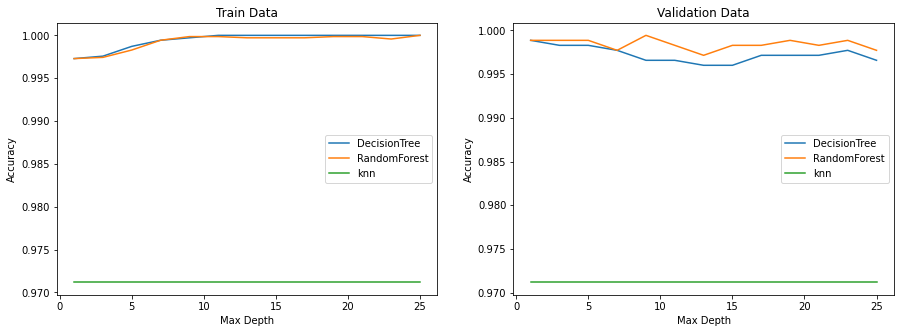

In [155]:

import scipy.stats 

class RandomForest416: 
    
    def __init__(self, num_trees, max_depth=None):

        self._trees = [
            DecisionTreeClassifier(max_depth=max_depth, random_state=1) 
            for i in range(num_trees)
        ]
        
    def fit(self, X, y):
        length_X = len(X)
        for tree in range(len(self._trees)):
            index = np.random.randint(length_X, size=length_X)
            selected_X = X.iloc[index]
            selected_y = y.iloc[index]
            self._trees[tree].fit(selected_X, selected_y)
          
        
            
    def predict(self, X):


        predictions = np.zeros((len(X), len(self._trees)))
        for i, tree in enumerate(self._trees):
            # Make predictions using the current tree
            preds = tree.predict(X)
            
            # Store those predictions in ith column of the 2d array
            predictions[:, i] = preds
            
        # For each row of predictions, find the most frequent label (axis=1 means across columns)
        return scipy.stats.mode(predictions, axis=1)[0]
# First calculate the accuracies for each depth
from sklearn.metrics import accuracy_score 
depths = list(range(1, 26, 2))
dt_accuracies = []
rf_accuracies = []
knn_accuracies = []

for i in depths:
    print(f'Depth {i}')

    # Train and evaluate a Decision Tree Classifier with given max_depth
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(train_data[features], train_data[target])
    dt_accuracies.append((
        accuracy_score(tree.predict(train_data[features]), train_data[target]),
        accuracy_score(tree.predict(validation_data[features]), validation_data[target])
    ))

    #parameters = {"n_neighbors": range(1, 50)}
    #knn = GridSearchCV(KNeighborsClassifier(), parameters)
    knn = KNeighborsClassifier()
    knn.fit(train_data[features], train_data[target])
    knn_accuracies.append((
        accuracy_score(knn.predict(train_data[features]), train_data[target]),
        accuracy_score(knn.predict(validation_data[features]), validation_data[target])
    ))
    
    # Train and evaluate our RandomForest classifier with given max_depth 
    rf = RandomForest416(15, max_depth=i)
    rf.fit(train_data[features], train_data[target])
    rf_accuracies.append((     
        accuracy_score(rf.predict(train_data[features]), train_data[target]),
        accuracy_score(rf.predict(validation_data[features]), validation_data[target])
    ))
    
# Then plot the scores
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training accuracies
axs[0].plot(depths, [acc[0] for acc in dt_accuracies], label='DecisionTree')
axs[0].plot(depths, [acc[0] for acc in rf_accuracies], label='RandomForest')
axs[0].plot(depths, [acc[0] for acc in knn_accuracies], label='knn')

# Plot validation accuracies
axs[1].plot(depths, [acc[1] for acc in dt_accuracies], label='DecisionTree')
axs[1].plot(depths, [acc[1] for acc in rf_accuracies], label='RandomForest')
axs[1].plot(depths, [acc[0] for acc in knn_accuracies], label='knn')

# Customize plots
axs[0].set_title('Train Data')
axs[1].set_title('Validation Data')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Accuracy')

# **4. Make Prediction using the best model**
Based on the roc curve as well as the validation accuracy graph above, we chose Random Forest as our best model for prediction.

In [156]:
# prediction on test set and output it into a csv file
predictions = model_forest.predict(test_data)
print(predictions)
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission.csv', index=False)

[1 0 1 ... 0 1 0]


# **5. Ethical implications problem**
We think it would involve the problem of educational inequity if the platform is trying to choose student groups based on factors such as specific country or certain educational backgrounds. All students should have equitible opportunities to access educational materials, however, if they were to be assessed, it should be based on the works they have done in courses and how much efforts they have put into the course. Furthermore, we think that students should be assessed individually, instead of stereotyping or generalizing them into groups. 